# Data Sourcing

sourced from: https://www.v-dem.net/data/the-v-dem-dataset/coder-level-v-dem/ 

suggested citation:  V-Dem Dataset:
Coppedge, Michael, John Gerring, Carl Henrik Knutsen, Staffan I. Lindberg, Jan Teorell, David Altman, Michael Bernhard, Agnes Cornell, M. Steven Fish, Lisa Gastaldi, Haakon Gjerløw, Adam Glynn, Ana Good God, Sandra Grahn, Allen Hicken, Katrin Kinzelbach, Joshua Krusell, Kyle L. Marquardt, Kelly McMann, Valeriya Mechkova, Juraj Medzihorsky, Natalia Natsika, Anja Neundorf, Pamela Paxton, Daniel Pemstein, Josefine Pernes, Oskar Ryd ́en, Johannes von R ̈omer, Brigitte Seim, Rachel Sigman, Svend-Erik Skaaning, Jeffrey Staton, Aksel Sund- str ̈om, Eitan Tzelgov, Yi-ting Wang, Tore Wig, Steven Wilson and Daniel Ziblatt. 2023. ”V-Dem [Country-Year/Country-Date] Dataset v13” Varieties of Democracy (V-Dem) Project. https://doi.org/10.23696/vdemds23.
and:
Pemstein, Daniel, Kyle L. Marquardt, Eitan Tzelgov, Yi-ting Wang, Juraj Medzihorsky, Joshua Krusell, Farhad Miri, and Johannes von R ̈omer. 2023. “The V-Dem Measurement Model: La- tent Variable Analysis for Cross-National and Cross-Temporal Expert-Coded Data”. V-Dem Working Paper No. 21. 8th edition. University of Gothenburg: Varieties of Democracy Insti- tute.

***the 2023 dataset***


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import scale as scl

/Users/maggiemyslik/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 1. Load Data
***the cell below takes around 5-10 minutes to run***

must have coder_level_ds_v13.csv in the vdem_coderdata (manually add) before running


In [2]:
coder_data = pd.read_csv('../data/vdem_coderdata/coder_level_ds_v13.csv')

/var/folders/hs/8m6m8lrn63g0q8cry5_vxbmm0000gn/T/ipykernel_18410/3260021198.py:1: DtypeWarning: Columns (1310) have mixed types. Specify dtype option on import or set low_memory=False.
  coder_data = pd.read_csv('../data/vdem_coderdata/coder_level_ds_v13.csv')


### 2. Filter for 2022 Data


In [3]:
coder_data["historical_date"] = pd.to_datetime(coder_data["historical_date"])
data_2022 = coder_data[coder_data["historical_date"].dt.year == 2022]

### 3. Filter Question Columns, Rescale all values between 0 and 4

In [4]:
question_columns = [
    col for col in data_2022.columns 
    if col.startswith(("v2", "v3")) 
    and not col.endswith(("_conf", "_beta")) 
    and not col.startswith("v2zz") 
    and not scl.get_variable_scale(col) == 2]

In [5]:
scaled_data_2022 = data_2022.copy()
for col in question_columns:
    scaled_data_2022[col] = scl.normalize_column_to_0_4(scaled_data_2022[col], col)

### 4. Assess Number of Coders for each Country and Question

In [6]:
coder_counts = data_2022.groupby("country_id")[question_columns].count()
coder_counts = coder_counts.reset_index()
coder_counts_long = coder_counts.melt(id_vars=["country_id"], 
                                      var_name="question", 
                                      value_name="num_coders")
coder_counts_long = coder_counts_long[coder_counts_long["num_coders"] > 0]
coder_counts_long = coder_counts_long.sort_values(by="num_coders", ascending=False)

In [7]:
min_entry = coder_counts_long.loc[coder_counts_long["num_coders"].idxmin()]
max_entry = coder_counts_long.loc[coder_counts_long["num_coders"].idxmax()]
median_value = coder_counts_long["num_coders"].median()
print(f"Minimum: {min_entry['num_coders']} coders for {min_entry['question']} in {min_entry['country_id']}")
print(f"Maximum: {max_entry['num_coders']} coders for {max_entry['question']} in {max_entry['country_id']}")
print(f"Median number of coders per question: {median_value}")

Minimum: 1 coders for v2lgcrrpt in 98
Maximum: 42 coders for v2eldonate in 76
Median number of coders per question: 10.0


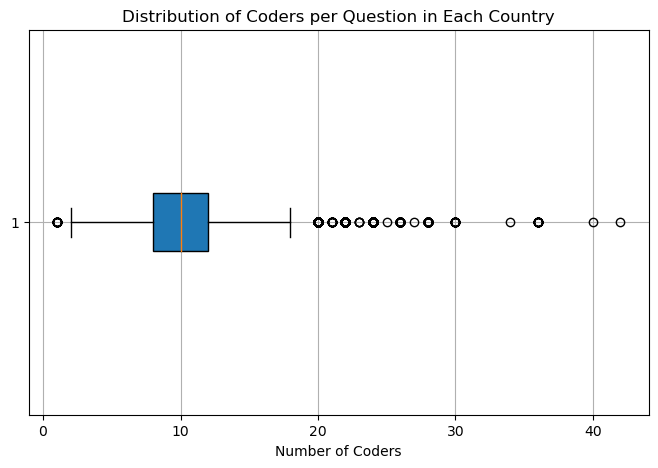

In [8]:
plt.figure(figsize=(8, 5))
plt.boxplot(coder_counts_long["num_coders"], vert=False, patch_artist=True)
plt.xlabel("Number of Coders")
plt.title("Distribution of Coders per Question in Each Country")
plt.grid(True)
plt.show()

### 5. Group by Question and Country, Calculate the Standard Deviations 

In [9]:
std_devs = scaled_data_2022.groupby(["country_id"])[question_columns].std().reset_index()
std_devs = std_devs.melt(id_vars=["country_id"], var_name="question", value_name="std_dev")

In [10]:
top_questions = ["v2dlunivl", "v2elfrcamp", "v2elpaidig", "v2elsnlsff"]

In [11]:
max_15_std = std_devs.nlargest(15, "std_dev")[["country_id", "question", "std_dev"]]
print("\nMaximum 5 Standard Deviations:")
print(max_15_std)


Maximum 5 Standard Deviations:
       country_id       question   std_dev
32533         146  v2regimpgroup  2.626397
33249         146     v2regpower  2.626397
33428         146    v2regproreg  2.626397
9874           36      v2dlunivl  2.309401
13785           5     v2elfrcamp  2.309401
14882          31     v2elpaidig  2.309401
15998          74     v2elsnlsff  2.309401
16054         130     v2elsnlsff  2.309401
16078         162     v2elsnlsff  2.309401
18605         197     v2exdjdshg  2.309401
22959          54     v2lglegplo  2.309401
29591          63     v2pepwrgeo  2.309401
32169         135     v2pssunpar  2.309401
33834           6     v2smarrest  2.309401
37871         109    v2smorgviol  2.309401


In [12]:
median_std = std_devs["std_dev"].median()
print(f"\nMedian Deviation: {median_std}")


Median Deviation: 0.7559289460184544


In [13]:
clean_std_devs = std_devs.dropna(subset=['std_dev'])

### 7. Analyze by Question

In [14]:
questions_devs = clean_std_devs.groupby("question")["std_dev"].median().reset_index()
questions_devs = questions_devs.sort_values(by="std_dev", ascending=False)

In [15]:
max_15_question_std = questions_devs.nlargest(15, "std_dev")[["question", "std_dev"]]
print("\nMaximum 15 Median Standard Deviations:")
print(max_15_question_std)


Maximum 15 Median Standard Deviations:
        question   std_dev
69    v2elpaidig  1.440239
152   v2psnatpar  1.307725
168  v2regsuploc  1.224745
95    v2exremhog  1.124365
164  v2regopploc  1.073313
82    v2exdfdshg  1.051748
63    v2elfrcamp  1.044595
47    v2csrlgcon  1.044466
70    v2elpdcamp  1.040347
32    v2clrgunev  1.032796
115   v2lglegpup  1.032796
75    v2elsnlsff  1.032796
42    v2cscnsult  1.032796
84    v2exdfpphg  1.032796
19    v2clacjust  1.027105


In [16]:
high_ordinal_sds = ["v2elpaidig", "v2psnatpar", "v2exremhog", "v2exdfdshg",
                    "v2elfrcamp", "v2csrlgcon", "v2elpdcamp", "v2clrgunev",
                     "v2lglegpup", "v2elsnlsff" , "v2exdfpphg", "v2cscnsult"]

In [17]:
filtered_high_ord_std_devs = std_devs[std_devs["question"].isin(high_ordinal_sds)]


In [18]:
vdem_id_to_iso = {
    36: 'AFG',  # Afghanistan
    12: 'ALB',  # Albania
    103: 'DZA',  # Algeria
    104: 'AGO',  # Angola
    37: 'ARG',  # Argentina
    105: 'ARM',  # Armenia
    67: 'AUS',  # Australia
    144: 'AUT',  # Austria
    106: 'AZE',  # Azerbaijan
    146: 'BHR',  # Bahrain
    24: 'BGD',  # Bangladesh
    147: 'BRB',  # Barbados
    107: 'BLR',  # Belarus
    148: 'BEL',  # Belgium
    52: 'BEN',  # Benin
    53: 'BTN',  # Bhutan
    25: 'BOL',  # Bolivia
    150: 'BIH',  # Bosnia and Herzegovina
    68: 'BWA',  # Botswana
    19: 'BRA',  # Brazil
    152: 'BGR',  # Bulgaria
    54: 'BFA',  # Burkina Faso
    10: 'MMR',  # Burma/Myanmar
    69: 'BDI',  # Burundi
    55: 'KHM',  # Cambodia
    108: 'CMR',  # Cameroon
    66: 'CAN',  # Canada
    70: 'CPV',  # Cape Verde (Cabo Verde)
    71: 'CAF',  # Central African Republic
    109: 'TCD',  # Chad
    72: 'CHL',  # Chile
    110: 'CHN',  # China
    15: 'COL',  # Colombia
    153: 'COM',  # Comoros
    73: 'CRI',  # Costa Rica
    154: 'HRV',  # Croatia
    155: 'CUB',  # Cuba
    156: 'CYP',  # Cyprus
    157: 'CZE',  # Czechia
    111: 'COD',  # DR Congo (Democratic Republic of the Congo)
    158: 'DNK',  # Denmark
    113: 'DJI',  # Djibouti
    114: 'DOM',  # Dominican Republic
    75: 'ECU',  # Ecuador
    13: 'EGY',  # Egypt
    22: 'SLV',  # El Salvador
    160: 'GNQ',  # Equatorial Guinea
    15: 'ERI',  # Eritrea
    161: 'EST',  # Estonia
    132: 'SWZ',  # Eswatini
    38: 'ETH',  # Ethiopia
    162: 'FJI',  # Fiji
    163: 'FIN',  # Finland
    76: 'FRA',  # France
    116: 'GAB',  # Gabon
    118: 'GEO',  # Georgia
    77: 'DEU',  # Germany
    7: 'GHA',  # Ghana
    164: 'GRC',  # Greece
    78: 'GTM',  # Guatemala
    63: 'GIN',  # Guinea
    119: 'GNB',  # Guinea-Bissau
    66: 'GUY',  # Guyana
    26: 'HTI',  # Haiti
    154: 'HND',  # Honduras
    120: 'HUN',  # Hungary
    121: 'ISL',  # Iceland
    39: 'IND',  # India
    56: 'IDN',  # Indonesia
    79: 'IRN',  # Iran
    80: 'IRQ',  # Iraq
    72: 'IRL',  # Ireland
    81: 'ISR',  # Israel
    82: 'ITA',  # Italy
    64: 'CIV',  # Ivory Coast
    122: 'JAM',  # Jamaica
    9: 'JPN',  # Japan
    83: 'JOR',  # Jordan
    84: 'KAZ',  # Kazakhstan
    40: 'KEN',  # Kenya
    43: 'XKX',  # Kosovo (manual ISO code used by World Bank, etc.)
    171: 'KWT',  # Kuwait
    122: 'KGZ',  # Kyrgyzstan
    123: 'LAO',  # Laos
    124: 'LBN',  # Lebanon
    85: 'LSO',  # Lesotho
    86: 'LBR',  # Liberia
    124: 'LBY',  # Libya
    173: 'LTU',  # Lithuania
    174: 'LUX',  # Luxembourg
    125: 'MDG',  # Madagascar
    87: 'MWI',  # Malawi
    177: 'MYS',  # Malaysia
    88: 'MDV',  # Maldives
    28: 'MLI',  # Mali
    178: 'MLT',  # Malta
    65: 'MRT',  # Mauritania
    180: 'MUS',  # Mauritius
    3: 'MEX',  # Mexico
    126: 'MDA',  # Moldova
    89: 'MNG',  # Mongolia
    183: 'MNE',  # Montenegro
    90: 'MAR',  # Morocco
    57: 'MOZ',  # Mozambique
    127: 'NAM',  # Namibia
    58: 'NPL',  # Nepal
    91: 'NLD',  # Netherlands
    59: 'NIC',  # Nicaragua
    60: 'NER',  # Niger
    45: 'NGA',  # Nigeria
    41: 'PRK',  # North Korea
    176: 'MKD',  # North Macedonia
    186: 'NOR',  # Norway
    94: 'QAT',  # Qatar
    29: 'PAK',  # Pakistan
    93: 'PNG',  # Papua New Guinea
    92: 'PRY',  # Paraguay
    30: 'PER',  # Peru
    46: 'PHL',  # Philippines
    17: 'POL',  # Poland
    21: 'PRT',  # Portugal
    95: 'RWA',  # Rwanda
    11: 'RUS',  # Russia
    96: 'SAU',  # Saudi Arabia
    97: 'SYR',  # Syria
    98: 'TUN',  # Tunisia
    99: 'TUR',  # Turkey
    74: 'TLS',  # Timor-Leste
    133: 'TJK',  # Tajikistan
    47: 'TZA',  # Tanzania
    49: 'THA',  # Thailand
    134: 'TGO',  # Togo
    135: 'TTO',  # Trinidad and Tobago
    136: 'TKM',  # Turkmenistan
    50: 'UGA',  # Uganda
    100: 'UKR',  # Ukraine
    207: 'ARE',  # United Arab Emirates
    101: 'GBR',  # United Kingdom
    20: 'USA',  # United States of America
    102: 'URY',  # Uruguay
    140: 'UZB',  # Uzbekistan
    206: 'VUT',  # Vanuatu
    51: 'VEN',  # Venezuela
    34: 'VNM',  # Vietnam
    61: 'ZMB',  # Zambia
    62: 'ZWE',  # Zimbabwe
}

In [19]:
top_ordinal_sds = (
    filtered_high_ord_std_devs
    .groupby("country_id", as_index=False)
    .agg(median_std_dev=("std_dev", "median"))
)
top_ordinal_sds["iso_a3"] = top_ordinal_sds["country_id"].map(vdem_id_to_iso)
top_ordinal_sds = top_ordinal_sds.dropna(subset=["iso_a3"])


In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt

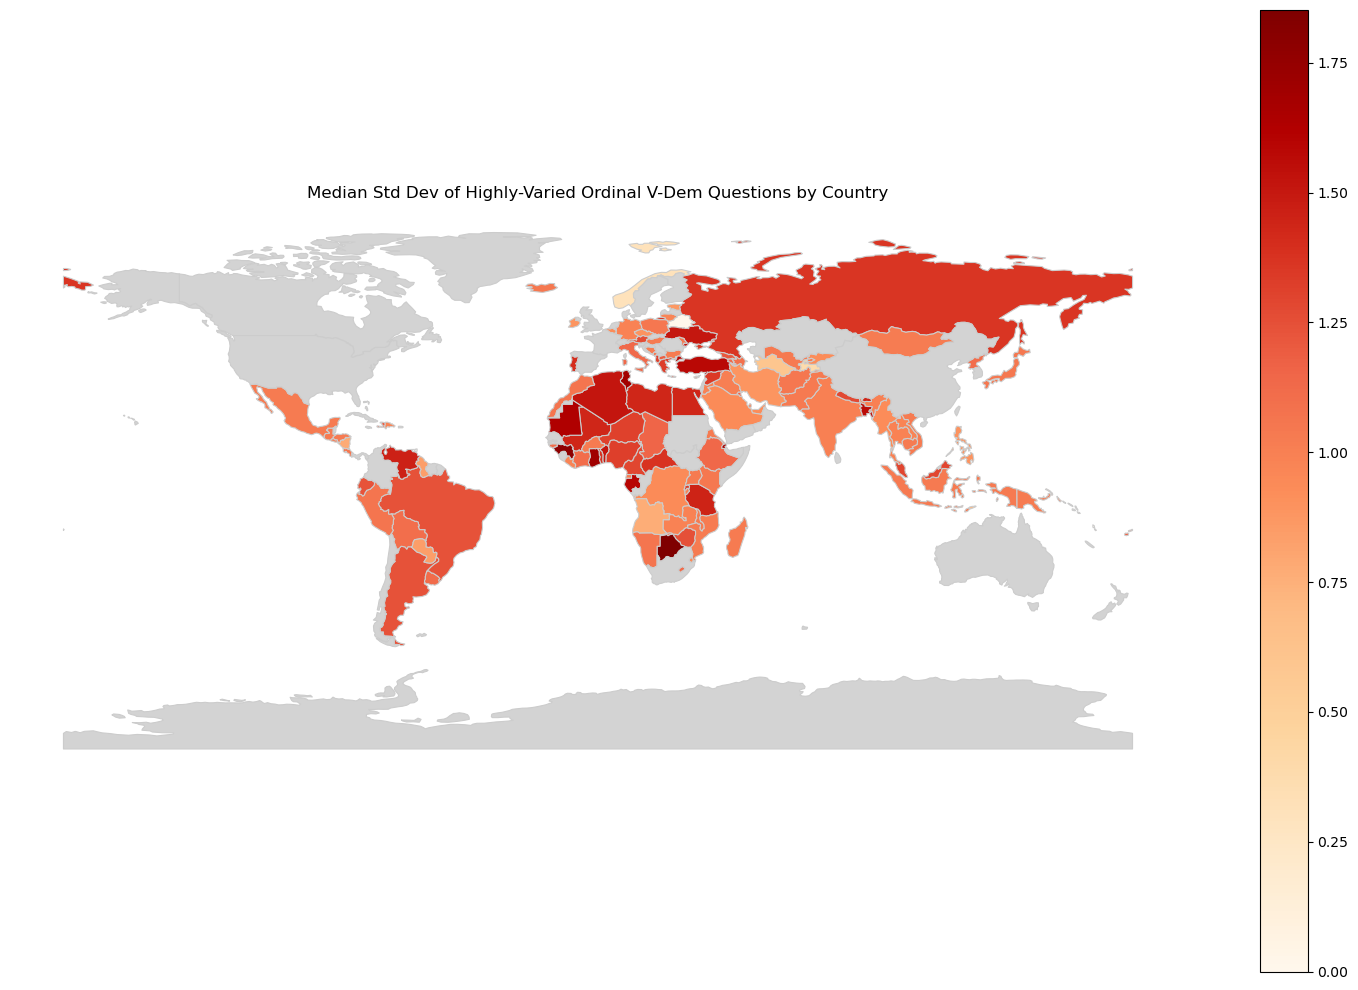

In [21]:
world = gpd.read_file("../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

merged = world.merge(top_ordinal_sds, left_on="SOV_A3", right_on="iso_a3", how="left")

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(
    column="median_std_dev",
    cmap="OrRd",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

ax.set_title("Median Std Dev of Highly-Varied Ordinal V-Dem Questions by Country")
ax.axis("off")
plt.tight_layout()
plt.show()

### Exploratory Histograms

In [28]:
id_columns = ['country_id', 'coder_id'] 
filtered_columns = id_columns + high_ordinal_sds
questions_of_interest_raw_data = scaled_data_2022[filtered_columns].copy()
questions_of_interest_raw_data['country_name'] = questions_of_interest_raw_data['country_id'].map(vdem_id_to_iso)


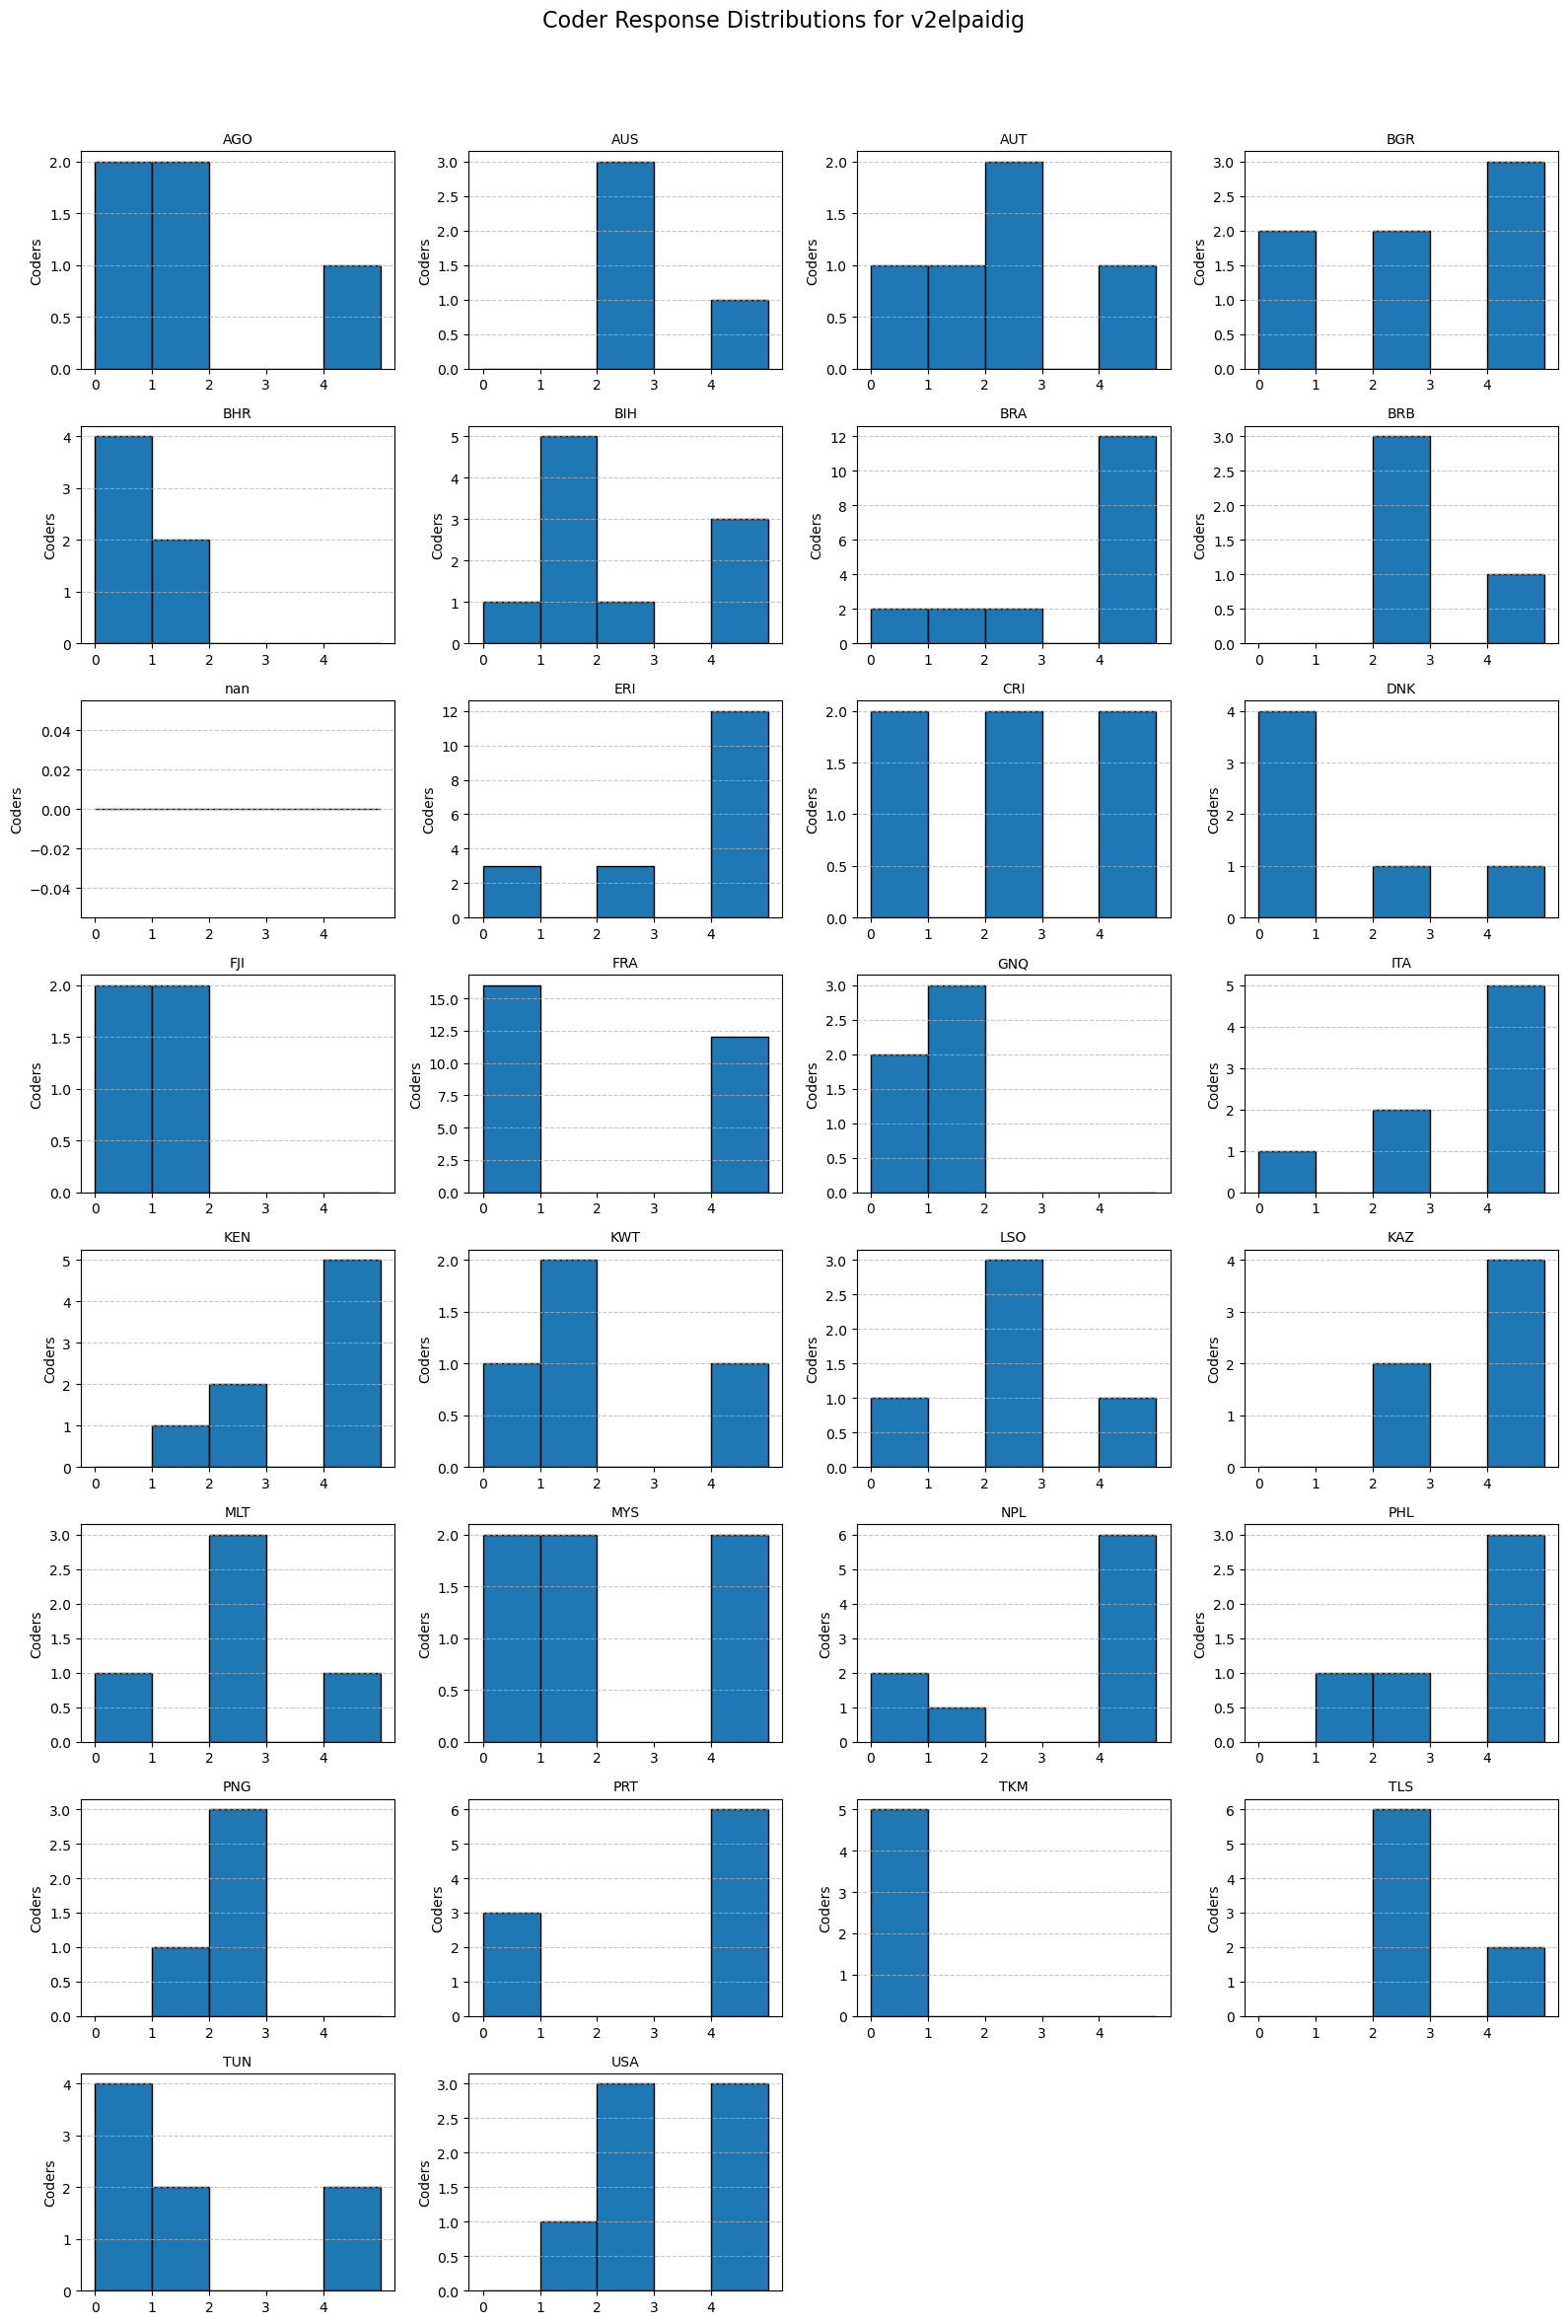

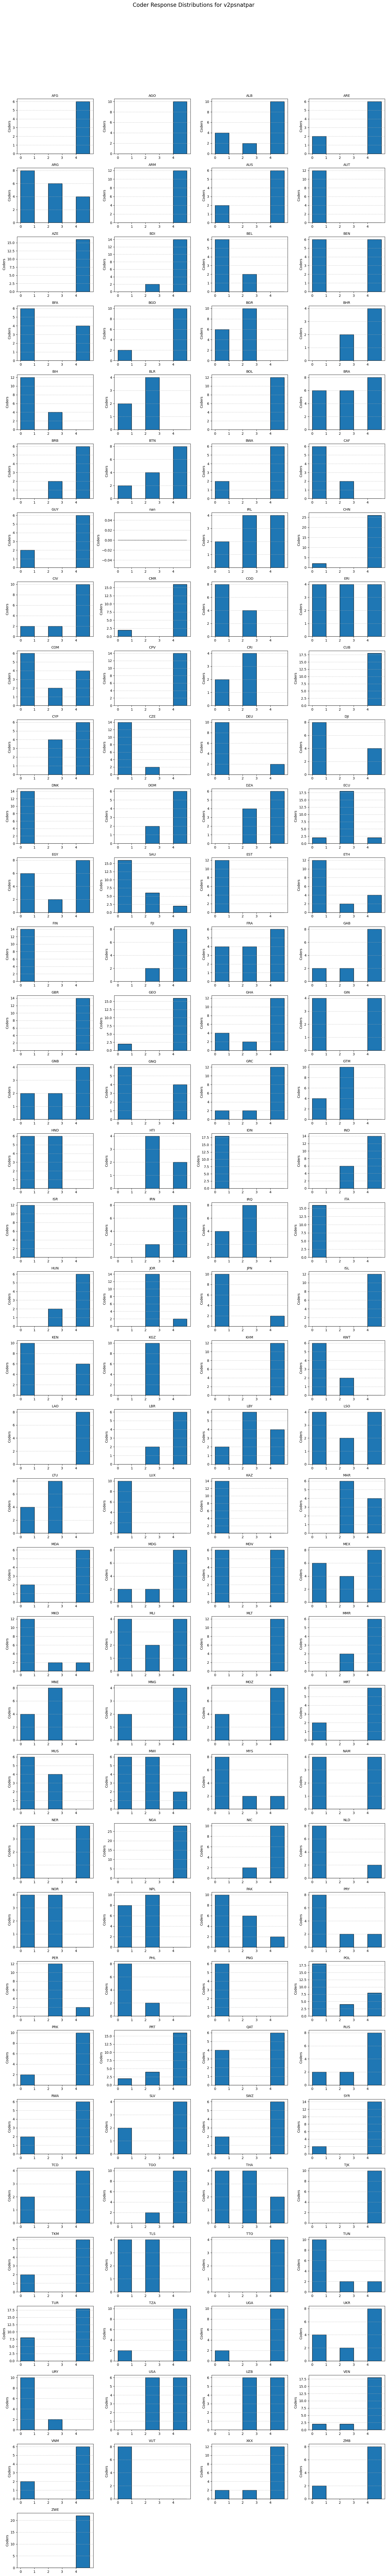

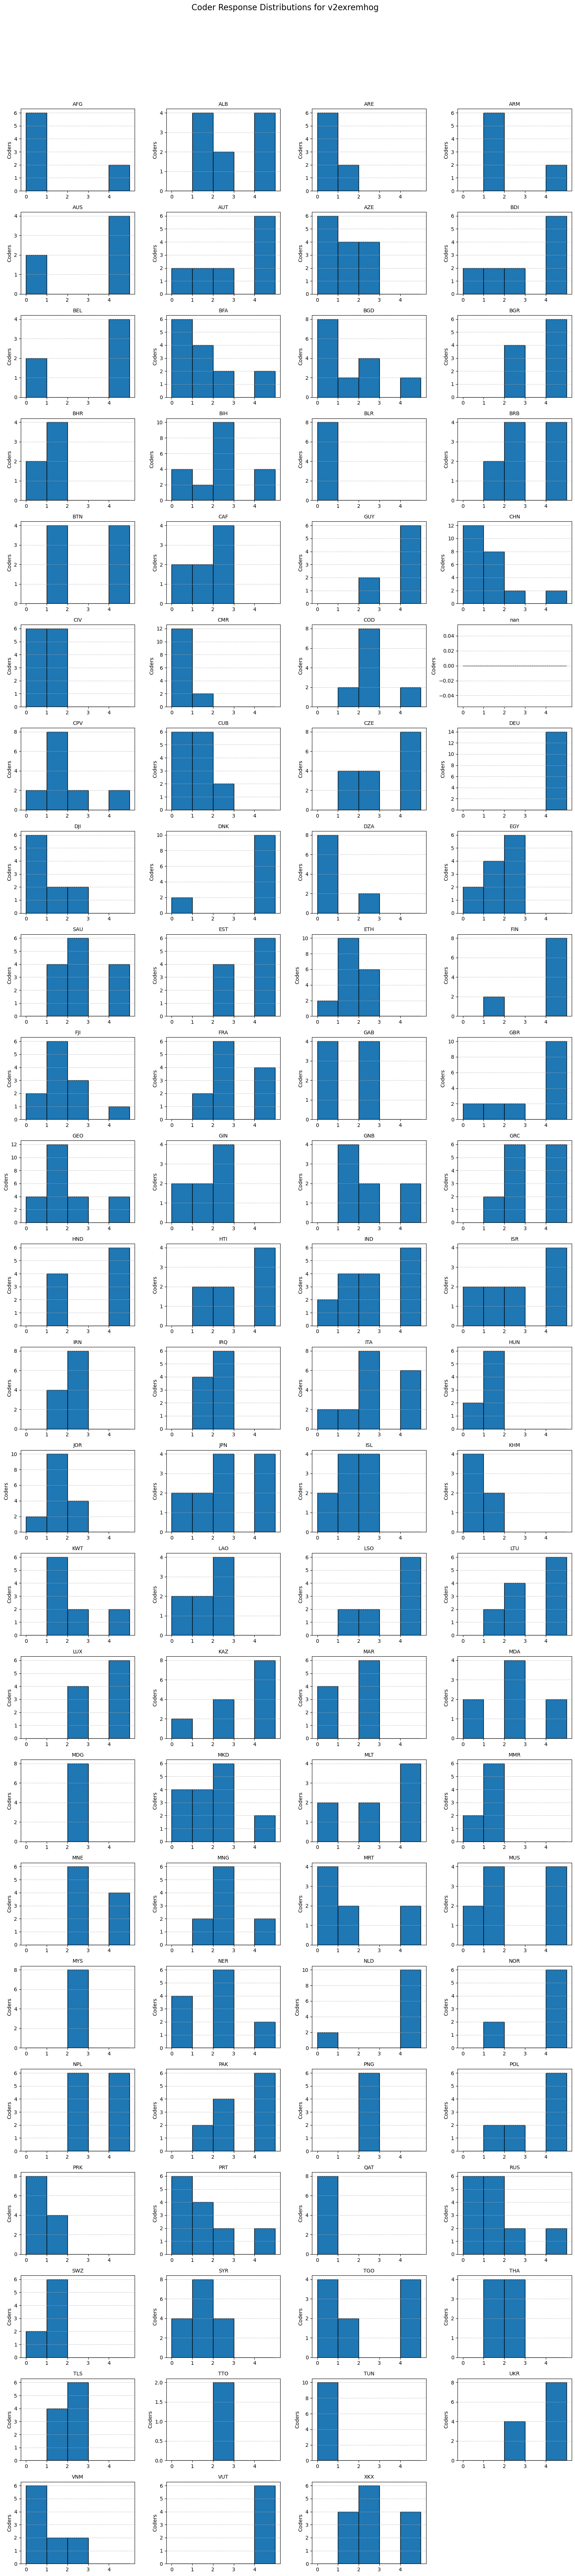

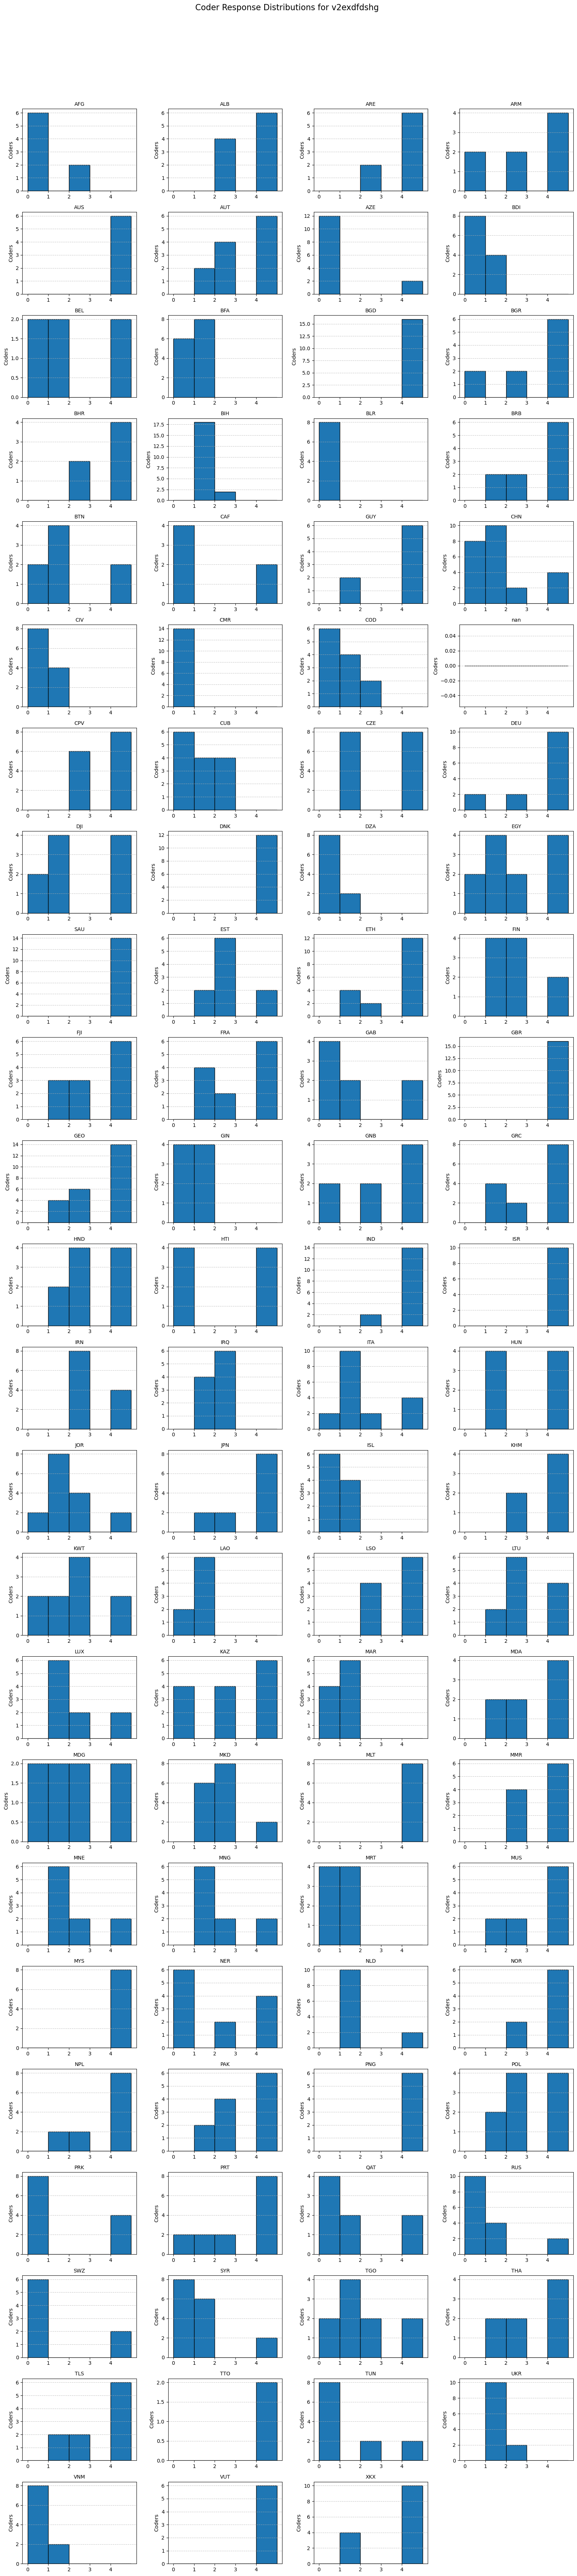

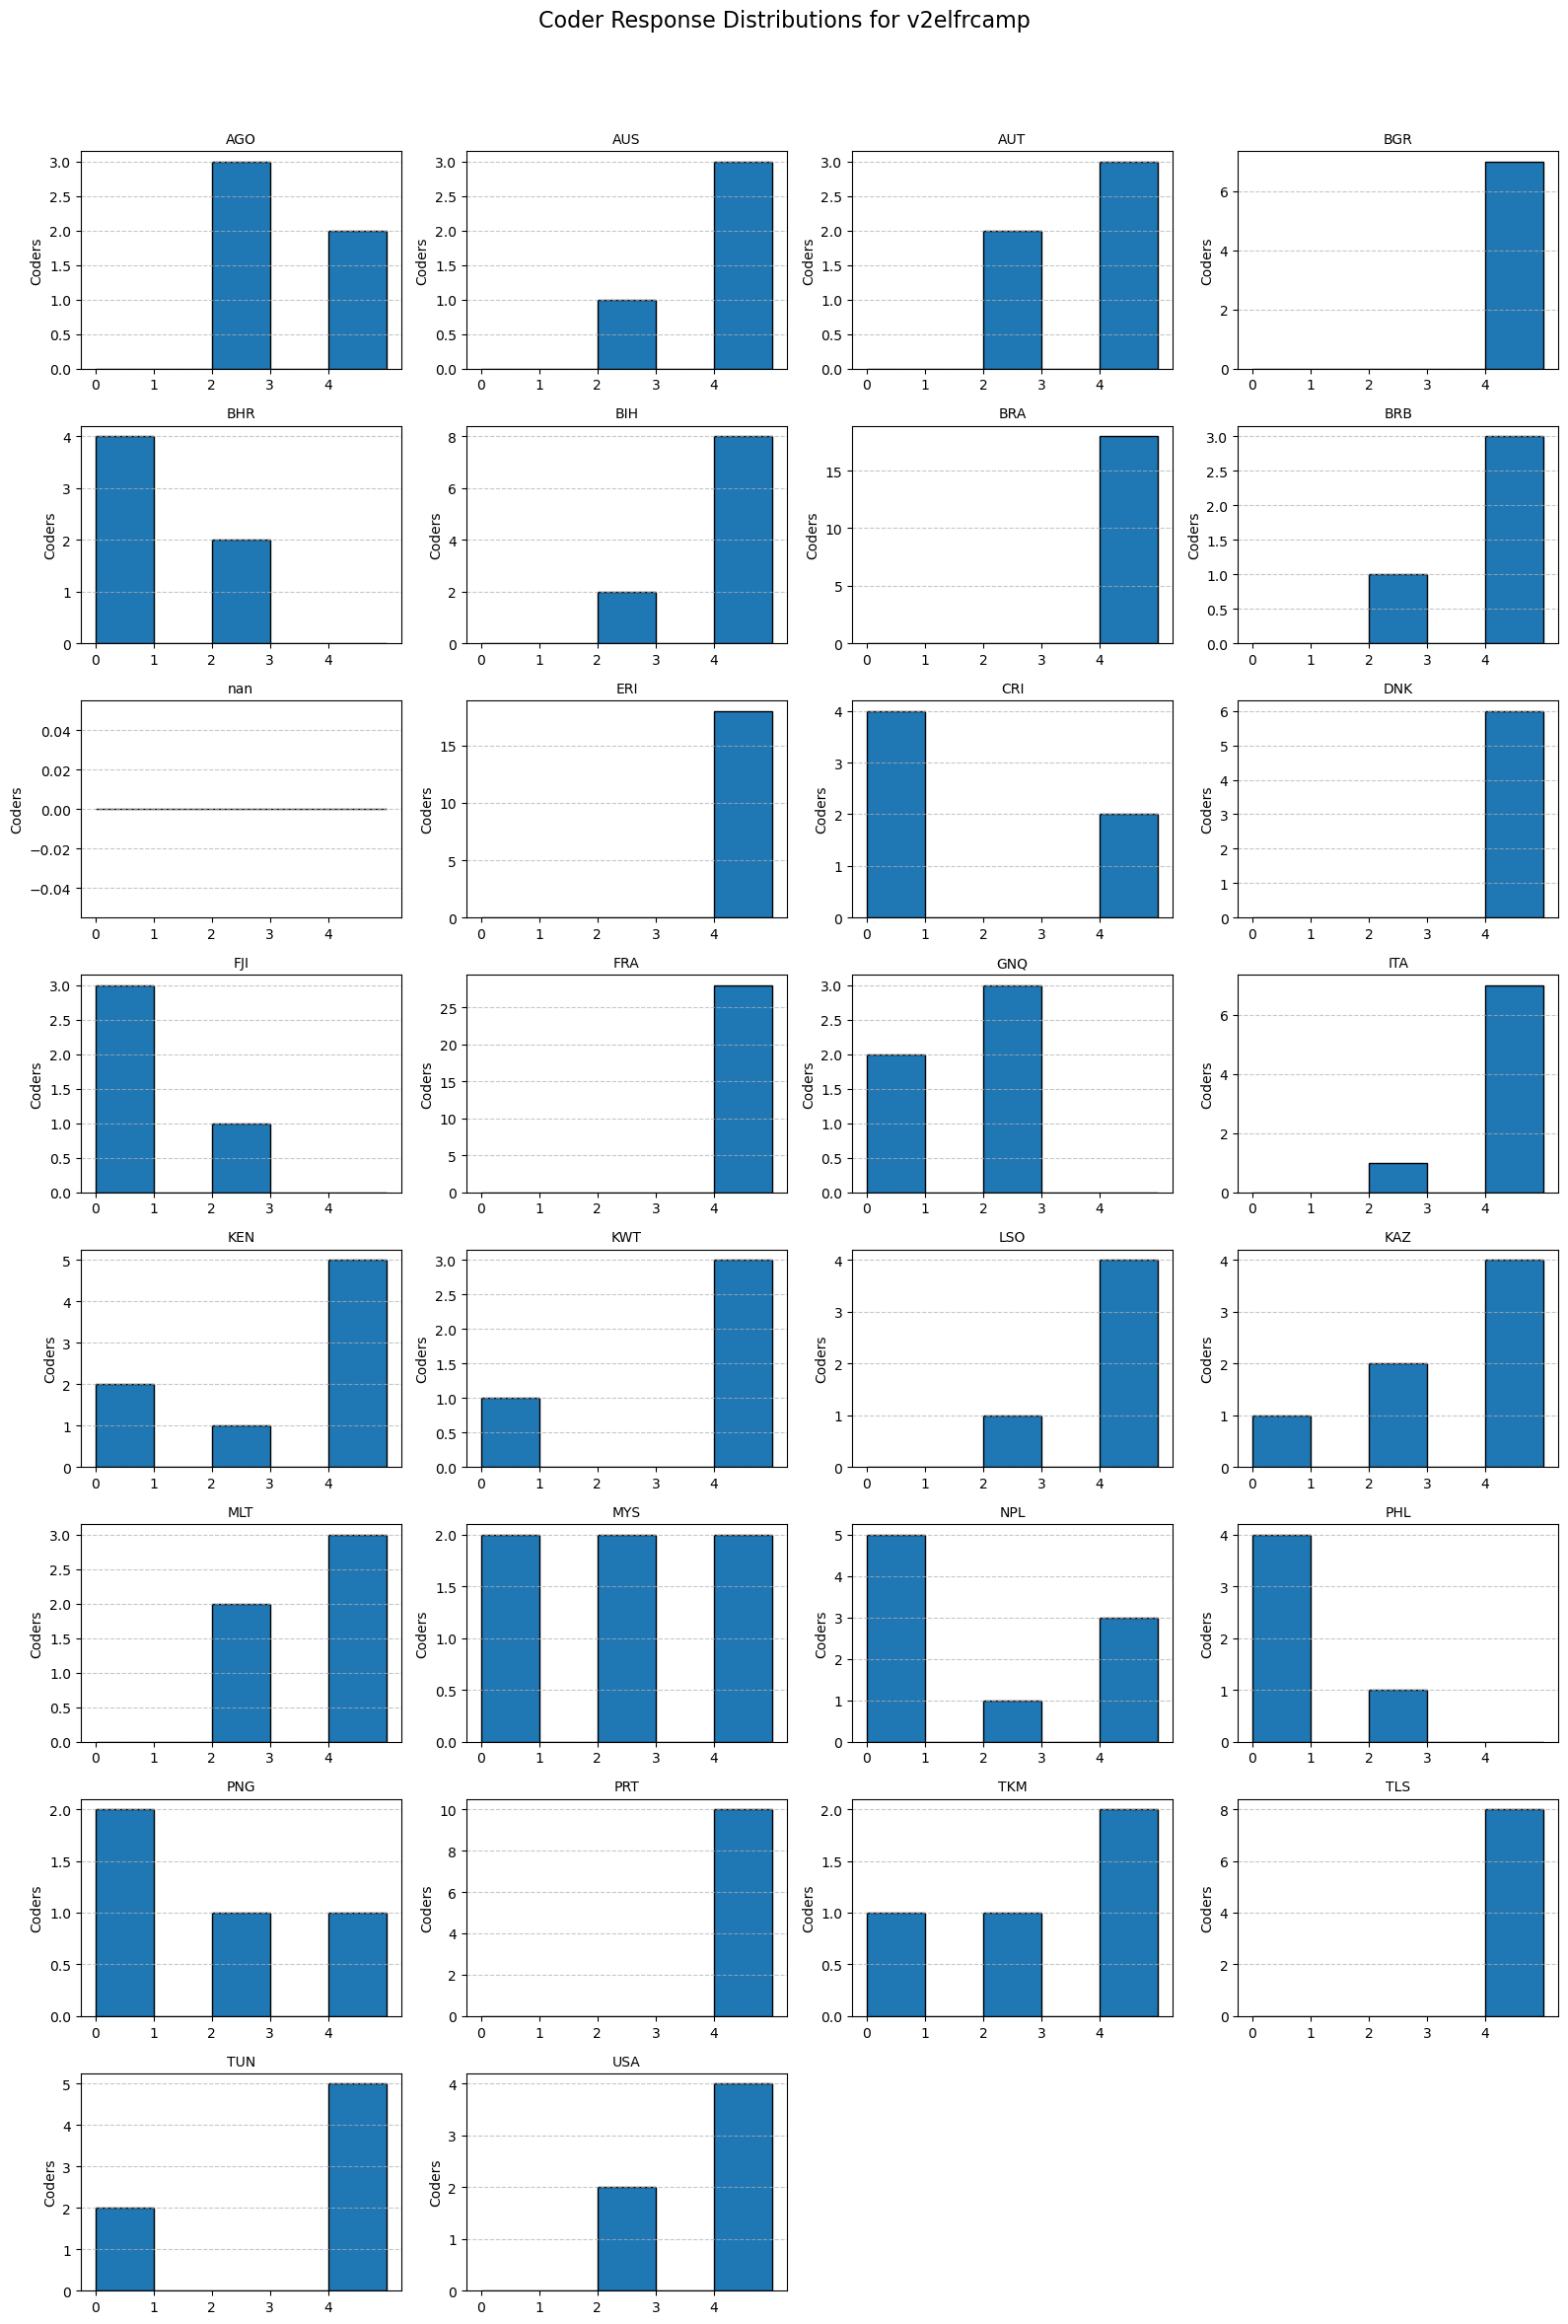

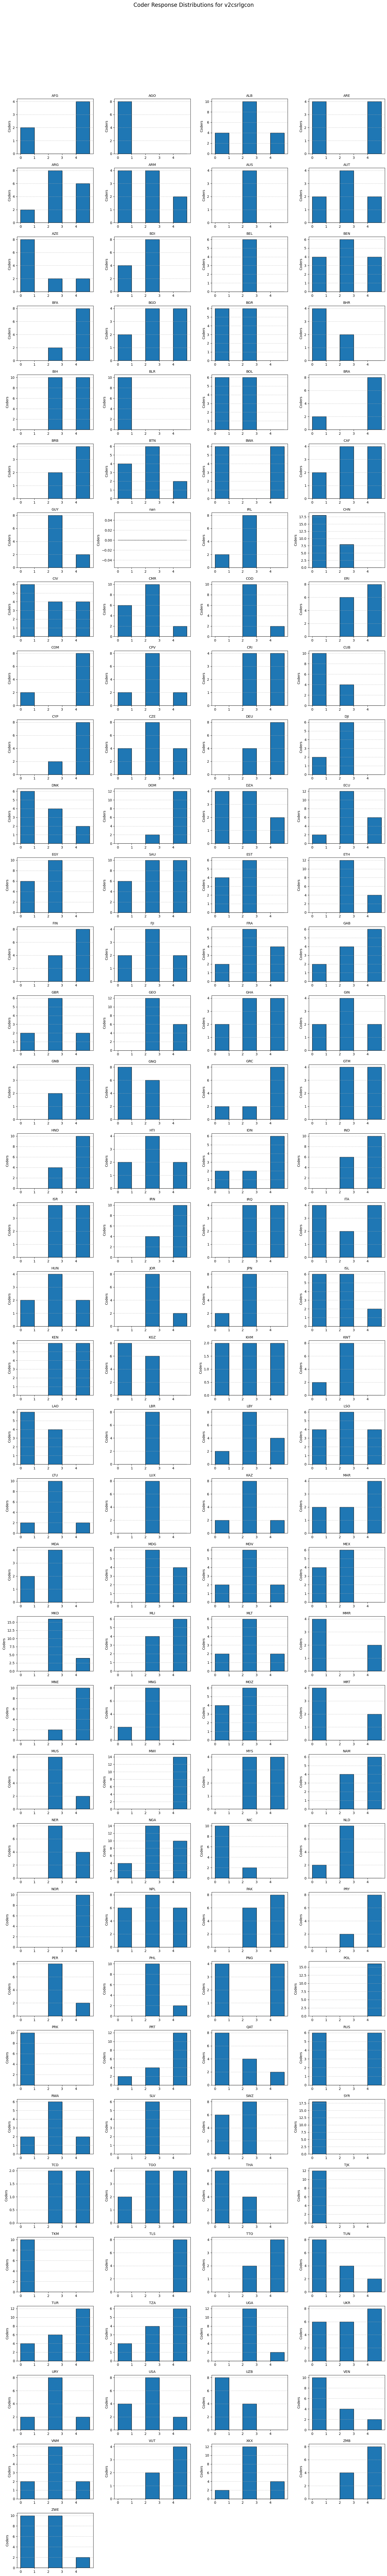

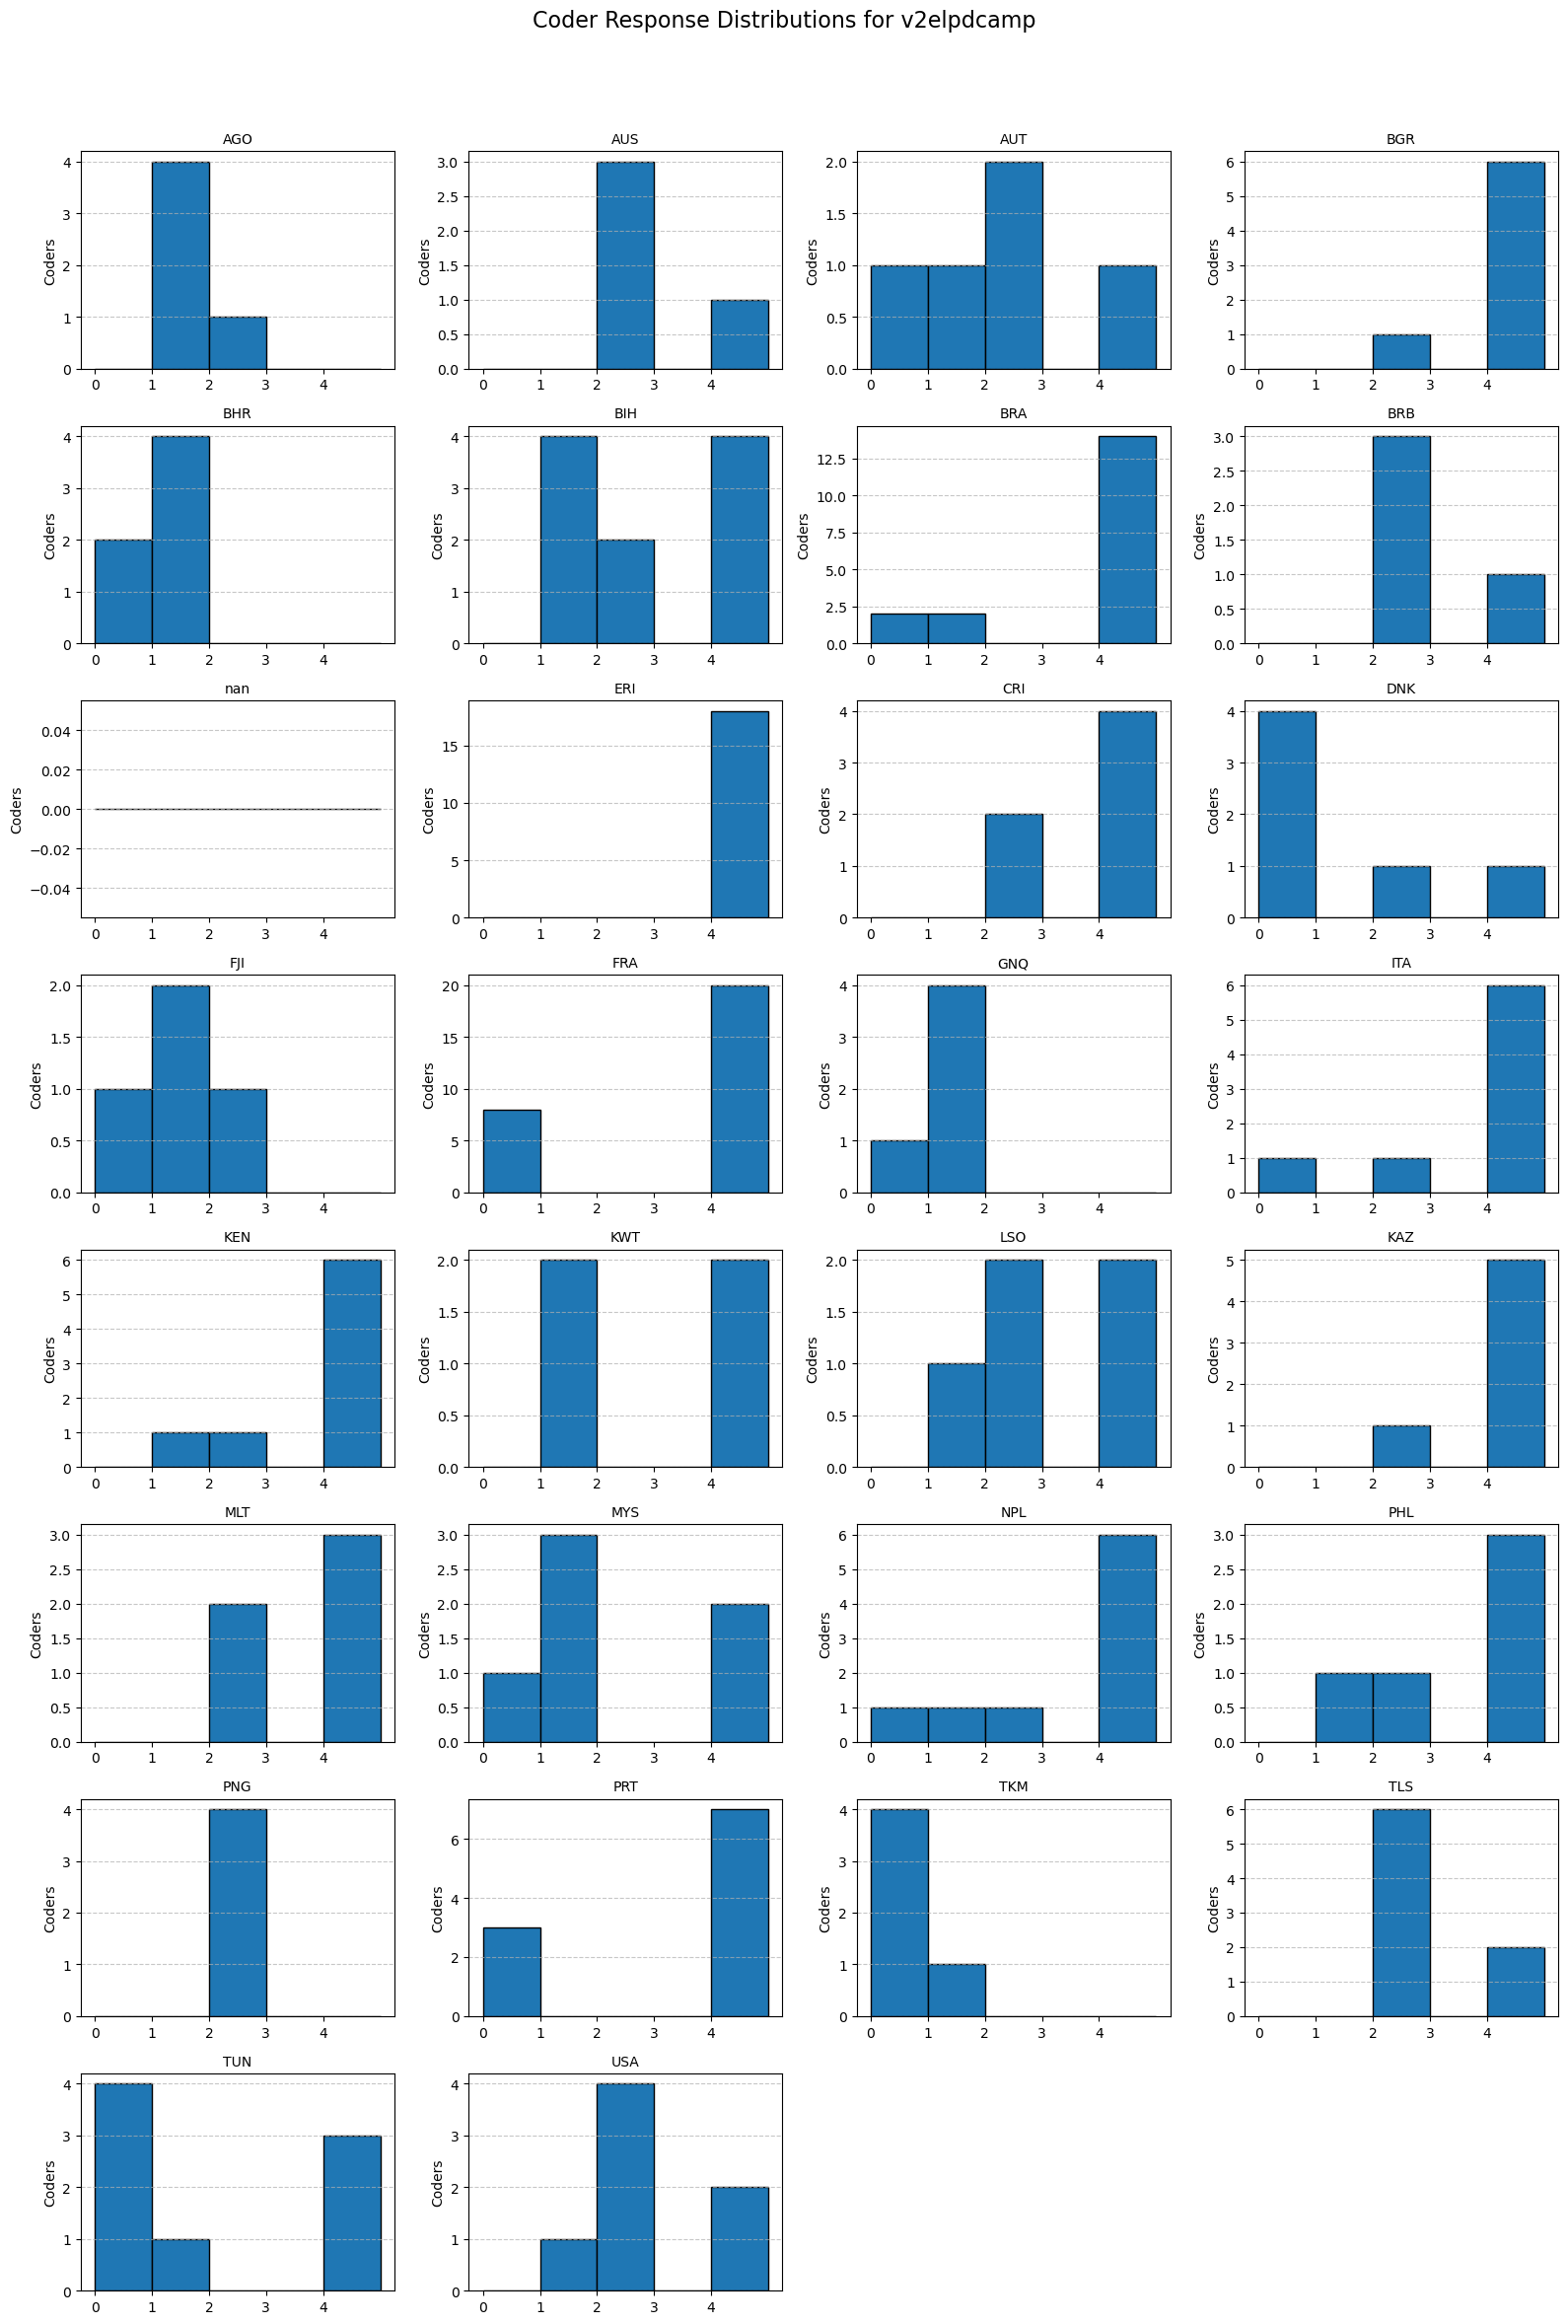

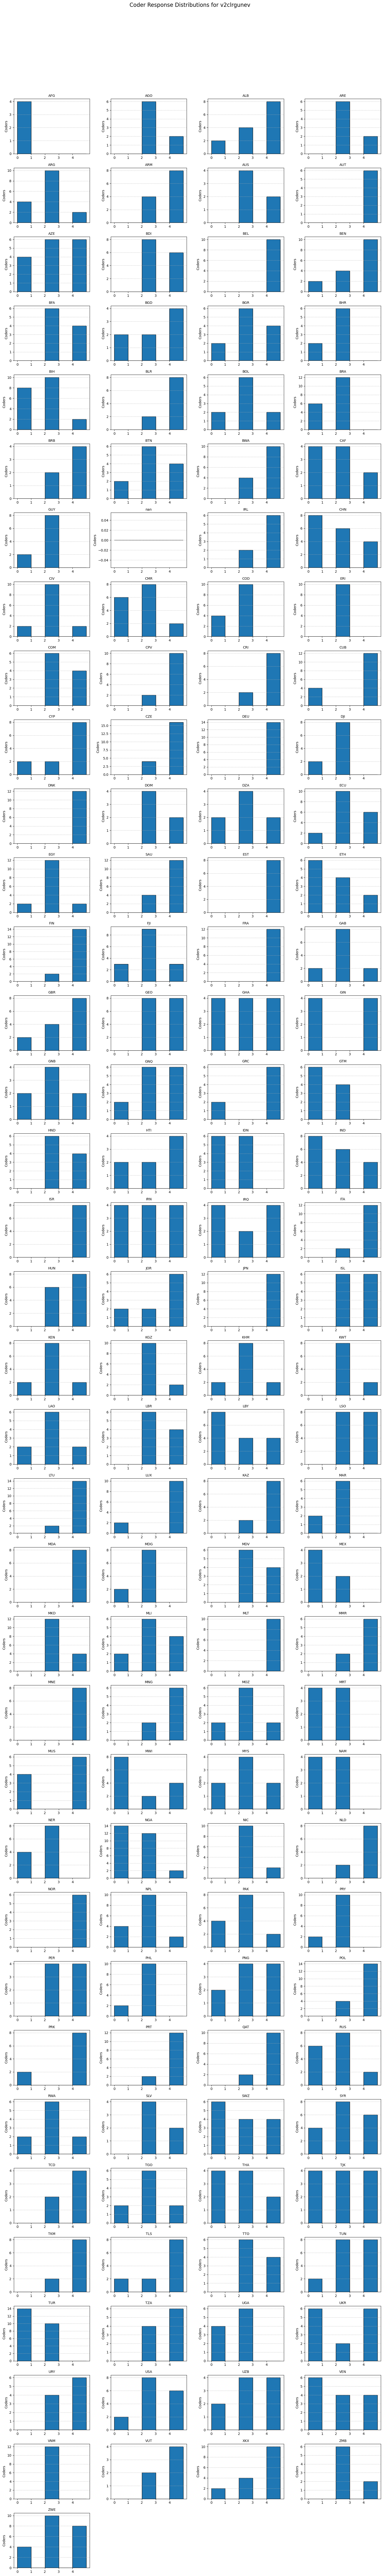

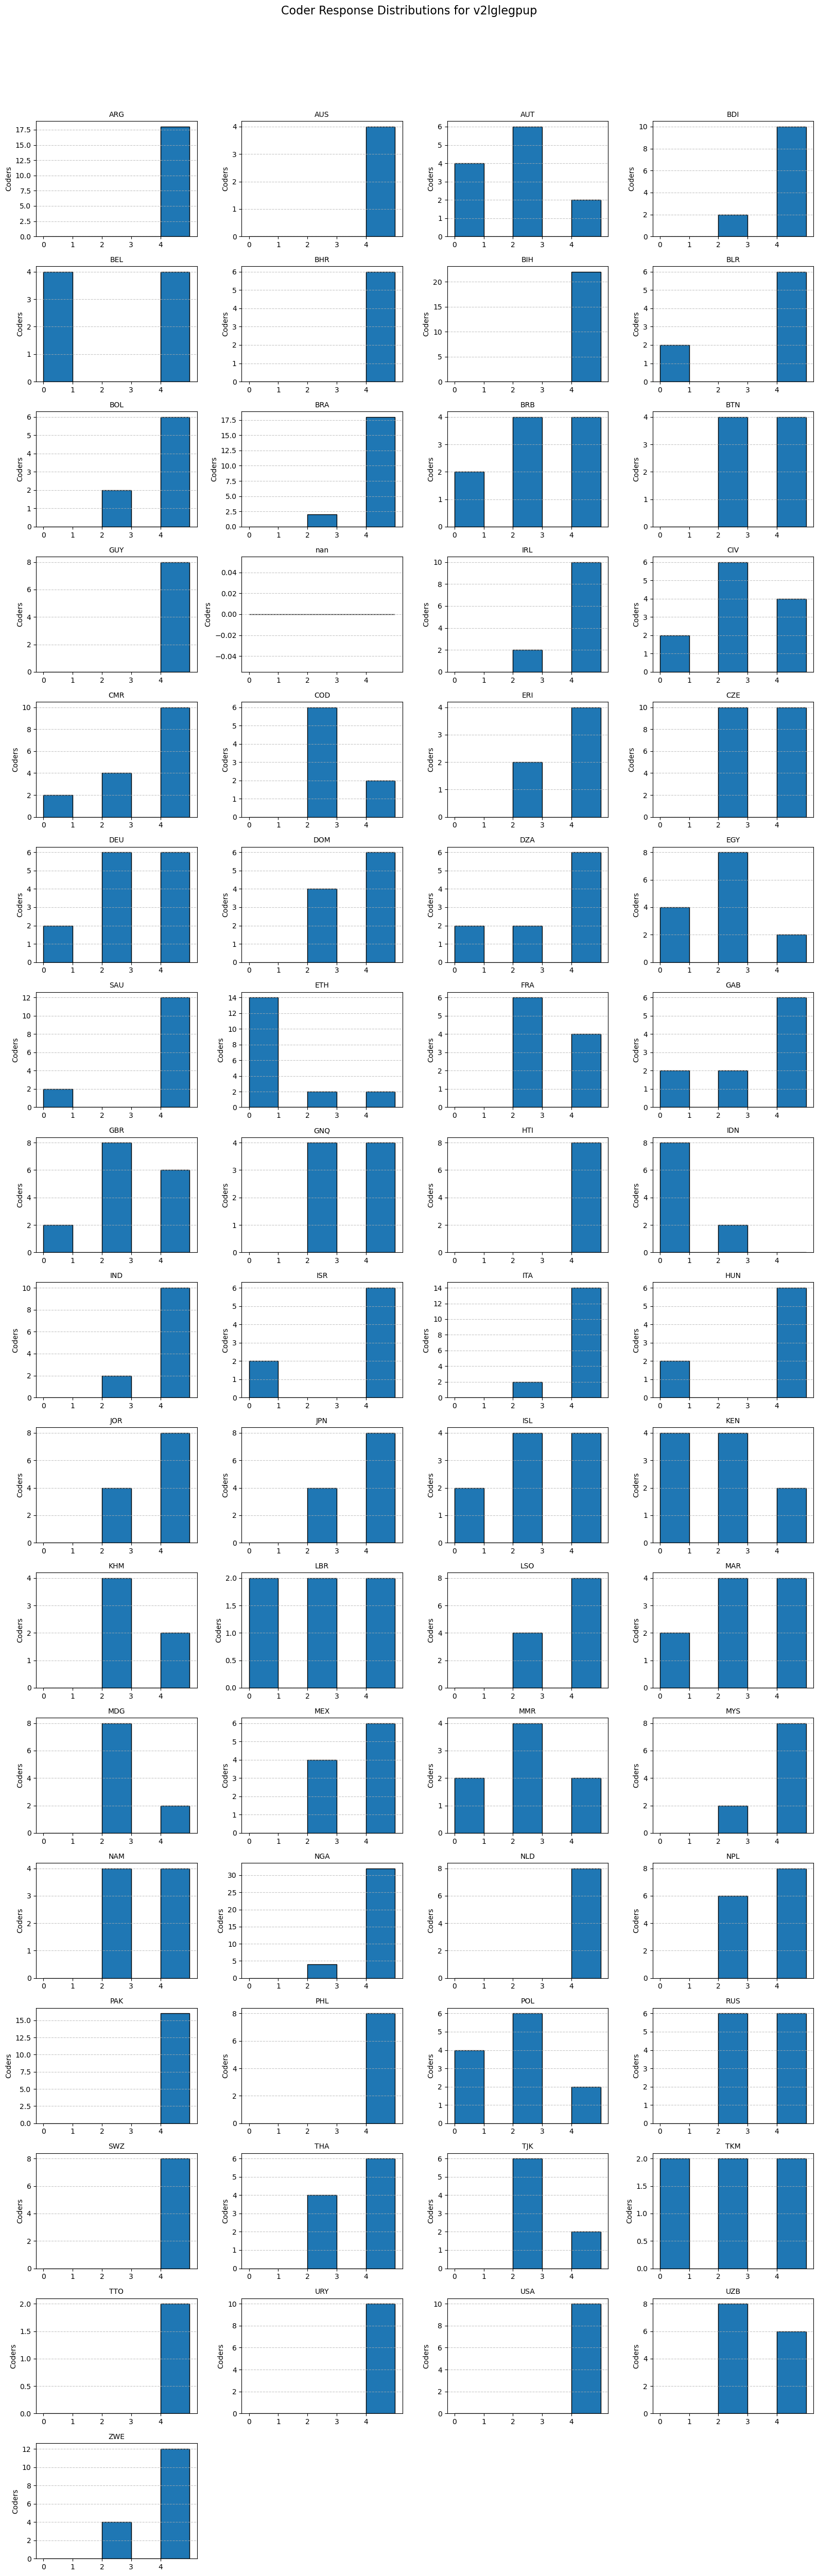

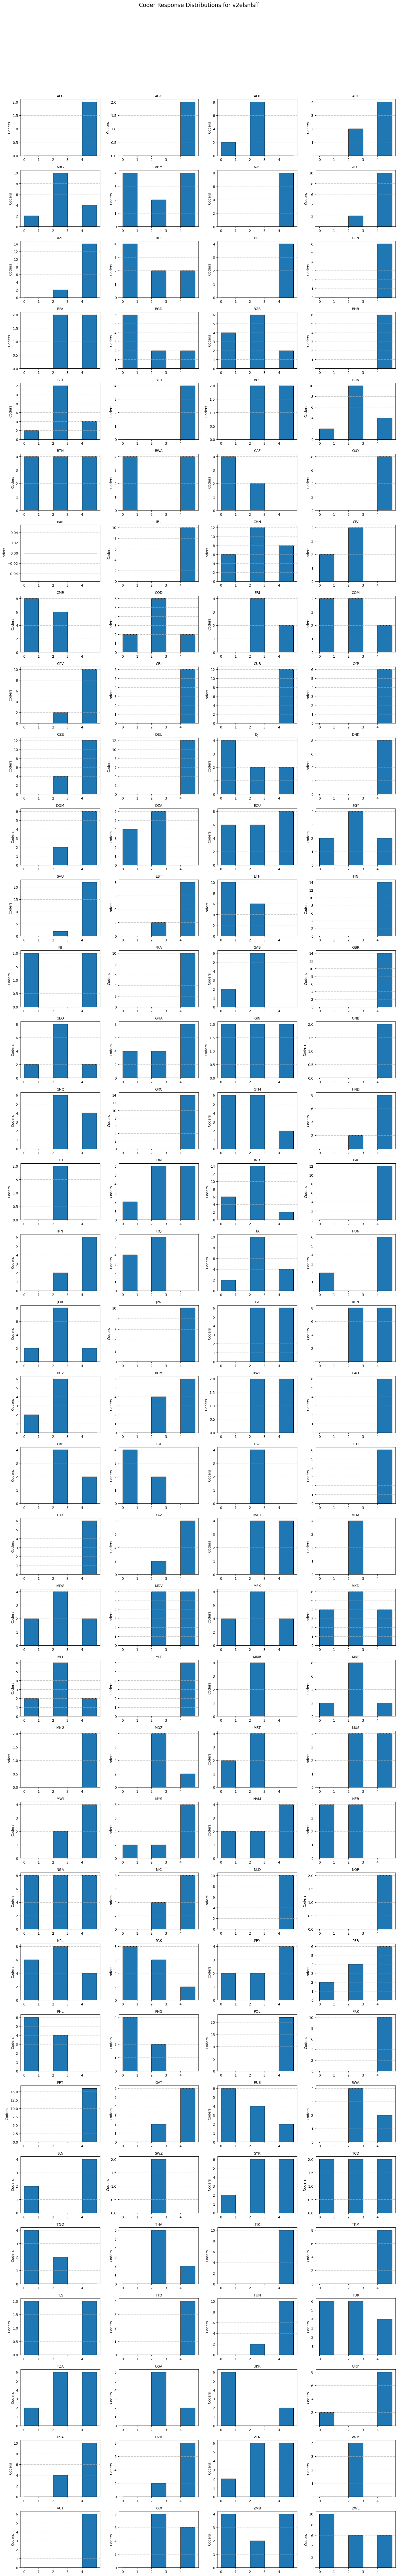

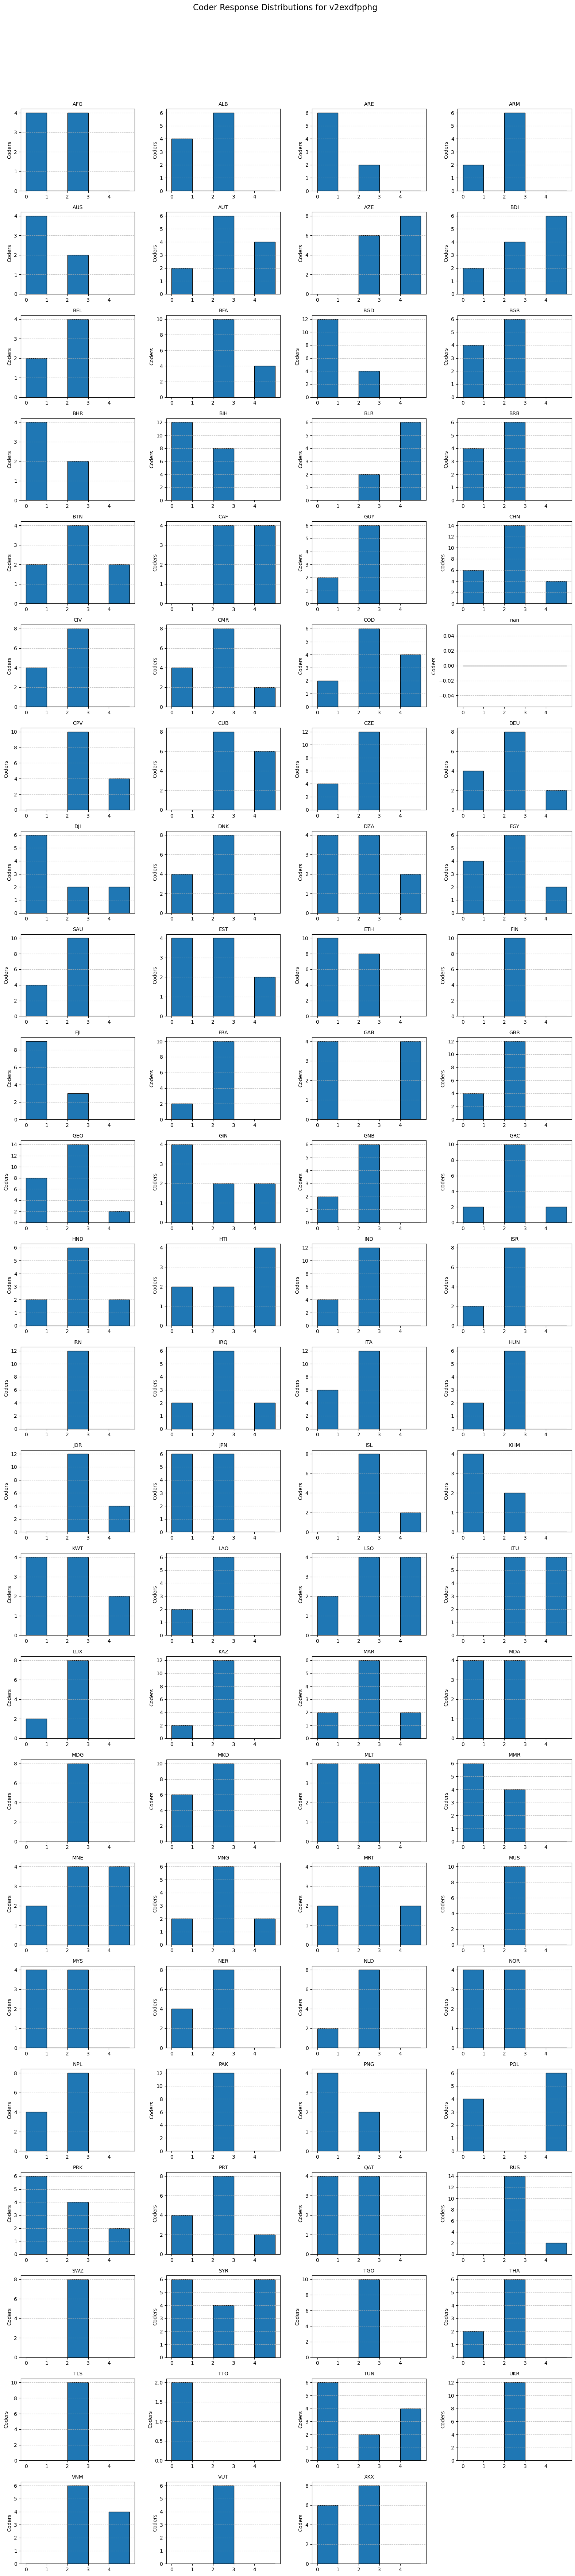

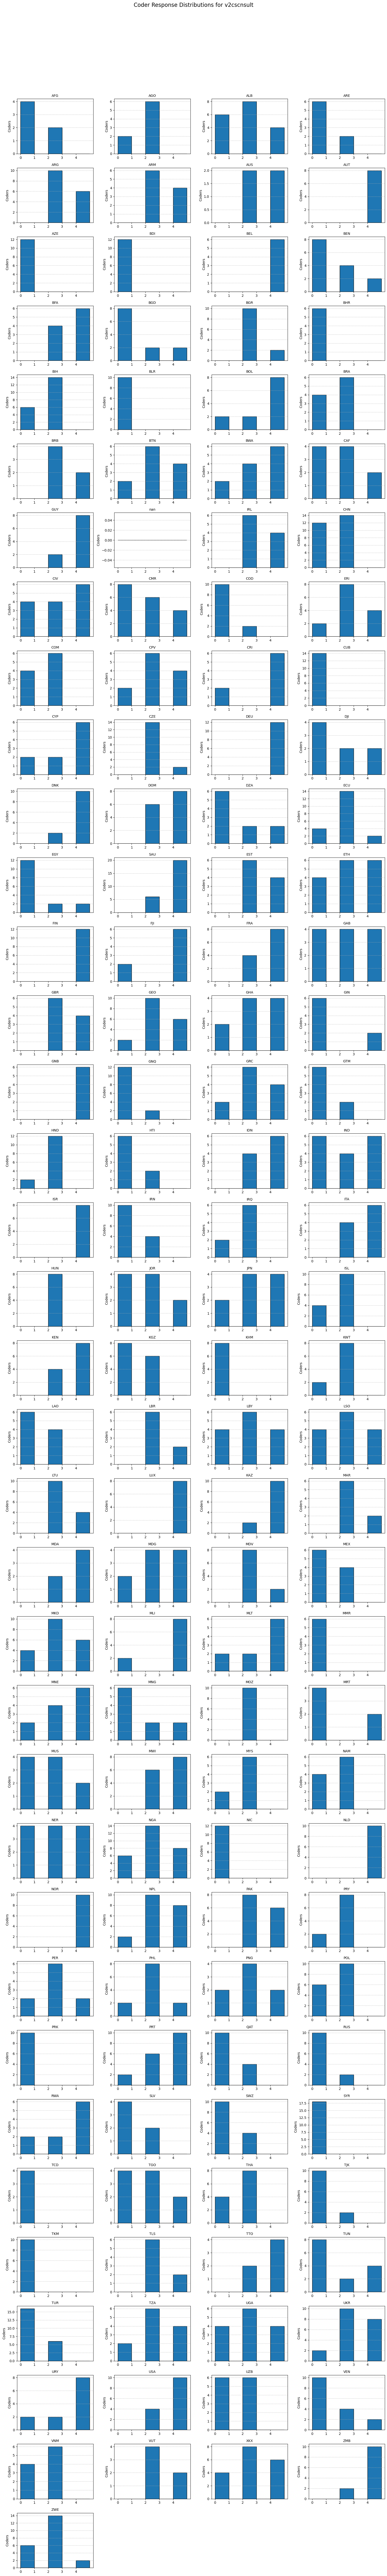

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Loop through each question
for question in high_ordinal_sds:
    questions_of_interest_raw_data[question] = pd.to_numeric(
        questions_of_interest_raw_data[question], errors='coerce'
    )

    non_null_data = questions_of_interest_raw_data.dropna(subset=[question])
    if non_null_data.empty:
        continue  # Skip if no valid data at all

    min_val = int(non_null_data[question].min())
    max_val = int(non_null_data[question].max())

    # Prepare country list with valid data for this question
    valid_countries = non_null_data['country_name'].unique()
    n_countries = len(valid_countries)
    n_cols = 4
    n_rows = math.ceil(n_countries / n_cols)

    # Create the subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), squeeze=False)
    fig.suptitle(f'Coder Response Distributions for {question}', fontsize=16)

    # Loop through countries and place each histogram in the correct subplot
    for idx, country in enumerate(valid_countries):
        row = idx // n_cols
        col = idx % n_cols

        ax = axes[row][col]
        country_df = non_null_data[non_null_data['country_name'] == country]

        ax.hist(
            country_df[question],
            bins=range(min_val, max_val + 2),
            edgecolor='black'
        )
        ax.set_title(country, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Coders')
        ax.set_xticks(range(min_val, max_val + 1))
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hide any empty subplots
    for idx in range(n_countries, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row][col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for suptitle
    plt.show()


In [29]:
questions_of_interest_raw_data.head(20)

country_id  coder_id  v2elpaidig  v2psnatpar  v2exremhog  v2exdfdshg  \
4735          36       706         NaN         NaN         4.0    0.000000   
4736          36       848         NaN         NaN         NaN         NaN   
4737          36      5512         NaN         NaN         0.0    0.000000   
4738          36      5563         NaN         4.0         0.0    0.000000   
4739          36      5896         NaN         4.0         NaN         NaN   
4740          36      6180         NaN         4.0         0.0    2.666667   
4741          36      8446         NaN         NaN         NaN         NaN   
4742          36      8478         NaN         NaN         NaN         NaN   
4743          36       706         NaN         NaN         4.0    0.000000   
4744          36       848         NaN         NaN         NaN         NaN   
4745          36      5512         NaN         NaN         0.0    0.000000   
4746          36      5563         NaN         4.0         0.0    0.000000   
4747          36      5896         NaN         4.0         NaN         NaN   
4748          36      6180         NaN         4.0         0.0    2.666667   
4749          36      8446         NaN         NaN         NaN         NaN   
4750          36      8478         NaN         NaN         NaN         NaN   
8528         104       639         NaN         4.0         NaN         NaN   
8529         104      2082         NaN         4.0         NaN         NaN   
8530         104      2083         NaN         4.0         NaN         NaN   
8531         104      4566         NaN         4.0         NaN         NaN   

      v2elfrcamp  v2csrlgcon  v2elpdcamp  v2clrgunev  v2lglegpup  v2elsnlsff  \
4735         NaN         4.0         NaN         NaN         NaN         NaN   
4736         NaN         NaN         NaN         NaN         NaN         NaN   
4737         NaN         NaN         NaN         NaN         NaN         NaN   
4738         NaN         0.0         NaN         0.0         NaN         NaN   
4739         NaN         4.0         NaN         0.0         NaN         4.0   
4740         NaN         NaN         NaN         NaN         NaN         NaN   
4741         NaN         NaN         NaN         NaN         NaN         NaN   
4742         NaN         NaN         NaN         NaN         NaN         NaN   
4743         NaN         4.0         NaN         NaN         NaN         NaN   
4744         NaN         NaN         NaN         NaN         NaN         NaN   
4745         NaN         NaN         NaN         NaN         NaN         NaN   
4746         NaN         0.0         NaN         0.0         NaN         NaN   
4747         NaN         4.0         NaN         0.0         NaN         4.0   
4748         NaN         NaN         NaN         NaN         NaN         NaN   
4749         NaN         NaN         NaN         NaN         NaN         NaN   
4750         NaN         NaN         NaN         NaN         NaN         NaN   
8528         NaN         0.0         NaN         2.0         NaN         NaN   
8529         NaN         NaN         NaN         NaN         NaN         NaN   
8530         NaN         0.0         NaN         4.0         NaN         NaN   
8531         NaN         0.0         NaN         2.0         NaN         NaN   

      v2exdfpphg  v2cscnsult country_name  
4735         0.0         2.0          AFG  
4736         NaN         NaN          AFG  
4737         0.0         NaN          AFG  
4738         2.0         0.0          AFG  
4739         NaN         0.0          AFG  
4740         2.0         NaN          AFG  
4741         NaN         NaN          AFG  
4742         NaN         NaN          AFG  
4743         0.0         2.0          AFG  
4744         NaN         NaN          AFG  
4745         0.0         NaN          AFG  
4746         2.0         0.0          AFG  
4747         NaN         0.0          AFG  
4748         2.0         NaN          AFG  
4749         NaN         N

# Cautionary Notes from VDem 
V-Dem is firmly committed to full transparency and release of the data that we have. However, we do ask users to take the following cautions into consideration when using our data.

- The V-Dem Methodology assumes five or more coders for the "contemporary" period starting from 1900, originally coded to 2012. With the updates covering 2013-2022 it has for a few country-variable combinations been impossible to achieve that target. From analysis, we have found that this at times can result in significant changes in point estimates, most likely as a consequence of self-selected attrition of Country Experts, rather than actual meaninful changes in the latent state of a given country. We therefore strongly advise against using point estimates for variable-years where a country has three or fewer ratings. We suggest to filter these out before conducting any type of analysis. Since v7, we include a variable that for every expert- coded variable, suffixed with "_nr", shows the count of ratings per country-year and variable.
- Point estimates can jump around slightly due to the simulation-based nature of the estimation process and expert turnover. Consumers of the data should therefore always be attentive to the uncertainty about the estimates. Further, the uncertainty also provides vital information about the degree to which one can be certain that a change in a score reflects an actual change in the level of the concept being measured.
- We constantly improve the coding of factual data (A) to make it as accurate as possible. This may result in changes at the index-level.
- Observations for Exclusion and Legitimation indicators (section 3.13 and section 3.14) with less than three coders per country-date (*_nr < 3) have been removed. Furthermore, observations for Exclusion indices (section 5.6) have been removed if not at least 3 components have at least 3 coders per country-date.
- Observations for Civic and Academic Space indicators (section 3.15) with less than 3 coders per country-date (*_nr < 3) have been removed.
- hese variables had issues with convergence: v2caconmob, v2cademmob, v2cainsaut, v2capolit, v2catrauni, v2clacjust, v2cltrnslw, v2dlcommon, v2dlencmps, v2elembcap, v2elffelrbin, v2elintim, v2elpdcamp, v2elpeace, v2elpubfin, v2exdjcbhg, v2jupoatck, v2lgdomchm, v2lginvstp, v2peasbgen, v2peasjgeo, v2peasjsoecon, v2pehealth, v2pepwrgeo, v2psprlnks, v2regoppgroupssize, v2smgovab, v2smpolhate, v2x_accountability, v2x_neopat, v2xdl_delib, v2xeg_eqdr, v2xlg_legcon, v2xnp_- client, v2xpe_exlecon, v2xpe_exlgender, v2xpe_exlgeo. Please see individual codebook entries for additional information. For details on interpreting convergence information, please refer to 1.4.5, the Methodology Document and Pemstein et al. (2023).
- We further ask you to use the following percentage variables with caution: 
  - Female journalists (v2mefemjrn)
  -  Weaker civil liberties population (v2clsnlpct)
- Historical V-Dem: In the coding of several Historical V-Dem A-type variables, the histori- cal part of the time series–including 20 years of overlap with the "contemporary" time series (typically 1900-1920)–were conducted completely independently from the existing coding in the original V-Dem dataset, by one or more new coders. For many of these historical variables, we have gone through and checked the consistency of the coding, further scrutinized the sources, and determined which coding represents the most appropriate score after deliberation. We have subsequently made the appropriate adjustments to the data.

For other historical A variables we have yet to finalize this process. For these variables, the scores reported for the overlap period (typically 1900-1920) in the dataset are the "contemporary" V- Dem scores, by default. This means that for some countries, where there is disagreement in the historical and contemporary coding in the starting year for the contemporary time series (typically 1900), there may be artificial changes between that year and the year before that do not necessarily reflect a real-world change in the political system in the country. Hence, we
  advise users to exert caution before running analysis on the entire time series extending across both the historical and contemporary coding periods.


Please also note that for the variables where there is not full correspondence between the his- torical (1789-1920) and contemporary (1900-2022) coding, the historical coding of the variables is also provided in their original form as separate variables, carrying a "v3" rather than a "v2" prefix on the variable tag. These "v3" variables are gathered together with a number of new (A and C type) variables that are currently only coded for the Historical V-Dem sample, in a separate section of the codebook.